## m5_flat_sed ##

m5_flat_sed provides a scaling calculation for m5, to adjust the m5 values for different FWHM, sky background, and exposure times. 

The scaling relationships in m5_flat_sed are based on C_m and dC_m values calculated by code in syseng_throughputs. These values are most appropriate for a given number of exposures within a visit, and as exposure time or sky background is varied, the resulting errors in the scaled magnitude (vs an m5 value calculated from 'scratch' with the full SNR formula) are < 0.02 mag. (see plots below)

As the number of exposures within a visit is changed, the resulting errors in the scaled magnitude are also slightly in error; in general these errors are larger than the scaled values from the same number of exposures/visit, but still remain < 0.02 mag. (see plots and tables below)

In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.syseng.throughputs as st
from lsst.sims.utils import m5_flat_sed, m5_scale
import lsst.sims.photUtils as photUtils

In [2]:
# Read the base throughput and SED files required, from the syseng_throughputs directory. 
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
defaultDirs = st.setDefaultDirs()

atmosphere = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(defaultDirs['atmosphere'], 'darksky.dat'))

hardware, system = st.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)

In [3]:
# Get the Cm/dCm_infinity/m5 values for various examples of the visit time
m5_1_15 = st.makeM5(hardware, system, exptime=15, nexp=1)
m5_2_15 = st.makeM5(hardware, system, exptime=15, nexp=2)
m5_1_30 = st.makeM5(hardware, system, exptime=30, nexp=1)

In [4]:
m5_2_15

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.988641,69.107171,26.897666,0.032339,0.050870,0.491829,0.038140,23.066504,0.631432,0.405153,23.764100,537.709569,23.9,23.4
g,0.87,0.76714,22.256461,402.681088,28.357487,0.124068,0.151018,0.213424,0.038734,24.414253,0.179280,0.094867,24.806430,789.848688,25.0,24.6
r,0.83,0.73426,21.196219,809.726438,28.143236,0.101849,0.114369,0.125876,0.038986,24.438509,0.097058,0.048254,24.351669,985.707537,24.7,24.3
i,0.80,0.70960,20.477858,1144.110445,27.829843,0.076313,0.083386,0.096232,0.039091,24.325059,0.070576,0.033985,23.919008,1100.157846,24.0,23.6
z,0.78,0.69316,19.599677,1713.369310,27.417680,0.052208,0.055617,0.068671,0.039221,24.157261,0.048230,0.022357,23.339608,1283.364512,23.3,22.9
y,0.76,0.67672,18.611811,2282.230987,26.639452,0.025494,0.029824,0.170304,0.039299,23.730151,0.036647,0.016459,22.446767,1426.248407,22.1,21.7


In [5]:
# Compare the particular columns that are used to calculate m5 in the scaling relations. kAtm and skyMag are same.
cols = ['kAtm', 'skyMag', 'gamma', 'Cm', 'dCm_infinity', 'm5']
m5_1_15[cols], m5_2_15[cols], m5_1_30[cols]

(       kAtm     skyMag     gamma         Cm  dCm_infinity         m5
 u  0.491829  22.988641  0.037396  23.055802      0.622630  23.377110
 g  0.213424  22.256461  0.038221  24.407022      0.177957  24.422912
 r  0.125876  21.196219  0.038573  24.432733      0.096511  23.969605
 i  0.096232  20.477858  0.038721  24.319891      0.070224  23.537553
 z  0.068671  19.599677  0.038903  24.152838      0.048027  22.958897
 y  0.170304  18.611811  0.039012  23.726175      0.036509  22.066503,
        kAtm     skyMag     gamma         Cm  dCm_infinity         m5
 u  0.491829  22.988641  0.038140  23.066504      0.631432  23.764100
 g  0.213424  22.256461  0.038734  24.414253      0.179280  24.806430
 r  0.125876  21.196219  0.038986  24.438509      0.097058  24.351669
 i  0.096232  20.477858  0.039091  24.325059      0.070576  23.919008
 z  0.068671  19.599677  0.039221  24.157261      0.048230  23.339608
 y  0.170304  18.611811  0.039299  23.730151      0.036647  22.446767,
        kAtm     s

In [6]:
# Standard coadd formula - this results in slightly incorrect values compared to a full SNR calculation.
# (due to coadding flux but not SNR)
def coadd_m5(m5s):
    result = 1.25*np.log10(np.sum(10.**(0.8*m5s), axis=0))
    return result

In [7]:
# Example of difference between coadd (m5 for 15s + m5 for 15s) vs. scratch calc of m5 for 2x15s visit
# The difference is largest in u band, where the readnoise is most significant 
# (and thus the assumption that SNR == flux is the most incorrect)
m5_a = st.makeM5(hardware, system, exptime=15, nexp=1)
m5_b = st.makeM5(hardware, system, exptime=15, nexp=1)
coaddVal = coadd_m5(np.array([m5_a['m5'], m5_b['m5']]))
m5_scratch = m5_2_15['m5']
t_2_15 = pd.DataFrame(m5_scratch).join(pd.DataFrame(coaddVal, index=filterlist, columns=['coaddM5']))
t_2_15 = t_2_15.assign(diff = t_2_15.m5 - t_2_15.coaddM5)
t_2_15

,m5,coaddM5,diff
u,23.764100,23.753398,0.010702
g,24.806430,24.799199,0.007231
r,24.351669,24.345893,0.005776
i,23.919008,23.913840,0.005168
z,23.339608,23.335185,0.004423
y,22.446767,22.442791,0.003976


In [8]:
# Let's compare scaling of m5 vs. 'from scratch' m5. (exposure time and sky background scaling)
# This sets the basic level of inaccuracy we're dealing with from not using a full calculation of SNR. 
lsstDefaults = photUtils.LSSTdefaults()
sky = deepcopy(darksky)

colors = {'u': 'cyan', 'g': 'g', 'r': 'orange' , 'i': 'r', 'y':'m', 'z':'k'}

In [12]:
# A shortcut to calculate m5 from scratch with variable sky background or exposure time.
def m5_calc(visitFilter, expTime, nexp, musky, sky, system, hardware, fwhm):
    photParams = photUtils.PhotometricParameters(exptime=expTime, nexp=nexp, gain=1.0, readnoise=8.8,
                                                othernoise=0, darkcurrent=0.2)
    fNorm = sky.calcFluxNorm(musky, hardware[visitFilter])
    sky.multiplyFluxNorm(fNorm)
    m5 = photUtils.calcM5(sky, system[visitFilter], hardware[visitFilter], 
                                   photParams, FWHMeff=fwhm)
    return m5

Text(0.5, 1.0, 'Varying sky background - single exposure per visit')

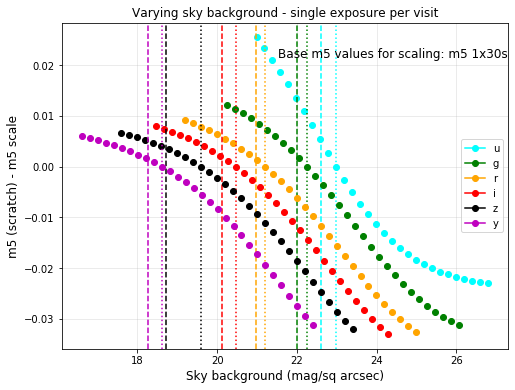

In [21]:
# Scale with sky background
m5_ex = m5_1_30
baseExp = 30

exptime = 30
nexp = 1 

medsky = {'u':22.61, 'g': 22.01, 'r': 20.98, 'i': 20.12, 'z': 18.72, 'y': 18.27}

plt.figure(figsize=(8,6))
for f in filterlist:
    i = 0
    darkskyback = m5_ex['skyMag'][f]
    for mu in np.arange(darkskyback-2, darkskyback+4, 0.2):
        m5_a = m5_calc(f, exptime, nexp, mu, sky, system, hardware, m5_ex['FWHMeff'][f])
        m5scale = m5_scale(exptime, nexp, 1.0, m5_1_30['FWHMeff'], mu, m5_ex['skyMag'], 
                            m5_ex['Cm'], m5_ex['dCm_infinity'], m5_ex['kAtm'], 0, baseExp)[f]
        if i == 0:
            label = f
            i += 1
        else:
            label = None
        plt.plot(mu, m5_a - m5scale, linestyle='-', marker='o', color=colors[f], label=label)
    plt.axvline(darkskyback, color=colors[f], linestyle=':')
    plt.axvline(medsky[f], color=colors[f], linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend(loc='right', numpoints=1)
plt.xlabel("Sky background (mag/sq arcsec)", fontsize='large')
plt.ylabel("m5 (scratch) - m5 scale", fontsize='large')
plt.figtext(0.5, 0.8, "Base m5 values for scaling: m5 1x30s", fontsize='large')
plt.title("Varying sky background - single exposure per visit", fontsize='large')

Text(0.5, 1.0, 'Varying exposure time - single exposure per visit')

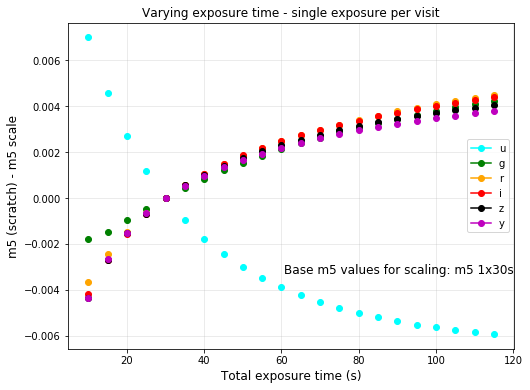

In [18]:
# Scale with exposure time.
m5_ex = m5_1_30
baseExp = 30

nexp = 1 


plt.figure(figsize=(8,6))
for exptime in np.arange(10, 120, 5):
    m5scale = m5_scale(exptime, nexp, 1.0, m5_ex['FWHMeff'], m5_ex['skyMag'], m5_ex['skyMag'], 
                       m5_ex['Cm'], m5_ex['dCm_infinity'], m5_ex['kAtm'], 0, baseExp)
    for f in filterlist:
        m5_a = m5_calc(f, exptime, nexp, m5_ex['skyMag'][f], sky, system, hardware, m5_ex['FWHMeff'][f])
        if exptime == 10:
            label = f
        else:
            label = None
        plt.plot(exptime, m5_a - m5scale[f], linestyle='-', marker='o', color=colors[f], label=label)
plt.grid(True, alpha=0.3)
plt.legend(loc='right', numpoints=1)
plt.xlabel("Total exposure time (s)", fontsize='large')
plt.ylabel("m5 (scratch) - m5 scale", fontsize='large')
plt.figtext(0.5, 0.3, "Base m5 values for scaling: m5 1x30s", fontsize='large')
plt.title("Varying exposure time - single exposure per visit", fontsize='large')

So, scaling relationship is not exact and will produce < 0.006 mag of error for exposure time scaling typically, whereas sky background scaling is <0.01 mag of error (based on median sky background values from simulations and range of skybackgrounds typically achieved). 

Text(0.5, 1.0, 'Varying exposure time - two exposures per visit')

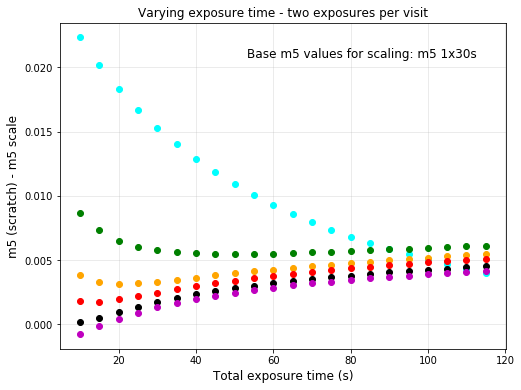

In [27]:
# Now - choose which set of C_m / dC_m values we should use 
# Given that we are most likely to have 1x30s visits but may also have 2x15s visits
# (and possibly could have varying exposure time)
# .... I mean, most likely the best answer is 1x30s 

m5_ex = m5_1_30
baseExp = 30

# Effect of error if  we have 2 exposures per visit instead of 1? (same total exposure time)
# This means there will be an error coming from scaling from 1x30s down to 1x15s, and then again from 
# coadding 1x15 + 1x15 to get the total m5 for a 2x15s visit.
nexp = 2

plt.figure(figsize=(8,6))
for exptime in np.arange(10, 120, 5):
    m5_a = st.makeM5(hardware, system, exptime=exptime/2, nexp=nexp)
    m5_calc = m5_scale(exptime/2, nexp, 1.0, m5_ex['FWHMeff'], m5_ex['skyMag'], m5_ex['skyMag'], 
                       m5_ex['Cm'], m5_ex['dCm_infinity'], m5_ex['kAtm'], 0, baseExp)
    for f in filterlist:
        plt.plot(exptime, m5_a['m5'][f] - m5_calc[f], linestyle='-', marker='o', color=colors[f])
plt.grid(True, alpha=0.3)
plt.xlabel("Total exposure time (s)", fontsize='large')
plt.ylabel("m5 (scratch) - m5 scale", fontsize='large')
plt.figtext(0.45, 0.8, "Base m5 values for scaling: m5 1x30s", fontsize='large')
plt.title("Varying exposure time - two exposures per visit", fontsize='large')

So -- using Cm/dCm values from the 1x30s visit to calculate m5 values for short 2x visits is not great -- 
More precisely: (for 1x30s vs. 2x15s)

In [29]:
# We know expected m5 value for 1x30s visit (m5_1_30), we know how far off coadd m5 (from 2 * m_1_15 is)
# How bad is scaled m5 value, when 1x30s values are used to calculate a 2x15 value?
m5_ex = m5_1_30
baseExp = 30

expTime = 15
nexp = 2

m5scale = {}
for f in filterlist:
    m5scale[f] = m5_scale(expTime, nexp, 1.0, m5_ex['FWHMeff'][f], m5_ex['skyMag'][f],
                         m5_ex['skyMag'][f], m5_ex['Cm'][f], m5_ex['dCm_infinity'][f], m5_ex['kAtm'][f], 0, baseExp)
m5scale = pd.DataFrame(m5scale, index=['m5_scaled']).T
m5scratch = m5_2_15['m5']
t_2_15 = pd.DataFrame(m5scratch).join(pd.DataFrame(m5scale))
t_2_15 = t_2_15.assign(diff2x15 = t_2_15.m5 - t_2_15.m5_scaled)
t_2_15

,m5,m5_scaled,diff2x15
u,23.764100,23.748827,0.015273
g,24.806430,24.800658,0.005772
r,24.351669,24.348338,0.003331
i,23.919008,23.916533,0.002475
z,23.339608,23.337884,0.001724
y,22.446767,22.445444,0.001323


Text(0.5, 1.0, 'Varying exposure time - single exposure per visit')

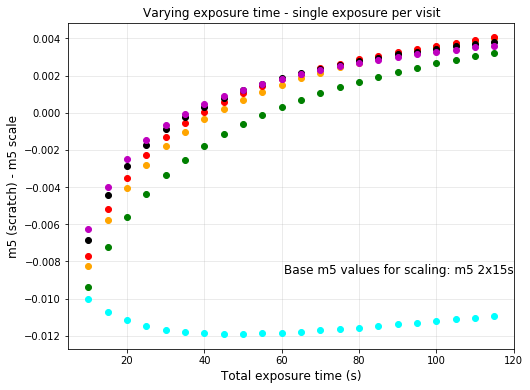

In [33]:
# And how bad would it be if we used some other Cm/dCm values as the base? 
# .. if we used 2x15s as the basis and were doing single exposures per visit? 
m5_ex = m5_2_15
baseExp = 15

plt.figure(figsize=(8,6))
for exptime in np.arange(10, 120, 5):
    m5_a = st.makeM5(hardware, system, exptime=exptime, nexp=1)
    m5_calc = m5_scale(exptime, 1, 1.0, m5_ex['FWHMeff'], m5_ex['skyMag'], m5_ex['skyMag'], 
                       m5_ex['Cm'], m5_ex['dCm_infinity'], m5_ex['kAtm'], 0, baseExp)
    for f in filterlist:
        plt.plot(exptime, m5_a['m5'][f] - m5_calc[f], linestyle='-', marker='o', color=colors[f])
plt.grid(True, alpha=0.3)
plt.xlabel("Total exposure time (s)", fontsize='large')
plt.ylabel("m5 (scratch) - m5 scale", fontsize='large')
plt.figtext(0.5, 0.3, "Base m5 values for scaling: m5 2x15s", fontsize='large')
plt.title("Varying exposure time - single exposure per visit", fontsize='large')

In [35]:
# We know expected m5 value for 1x30s visit (m5_1_30), we know how far off coadd m5 (from 2 * m_1_15 is)
# How bad is scaled m5 value, when 1x30s values are used to calculate a 2x15 value?
m5_ex = m5_2_15
baseExp = 15

expTime = 30
nexp = 1

m5scale = {}
for f in filterlist:
    m5scale[f] = m5_scale(expTime, nexp, 1.0, m5_ex['FWHMeff'][f], m5_ex['skyMag'][f],
                         m5_ex['skyMag'][f], m5_ex['Cm'][f], m5_ex['dCm_infinity'][f], m5_ex['kAtm'][f], 0, baseExp)
m5scale = pd.DataFrame(m5scale, index=['m5_scaled']).T
m5scratch = m5_1_30['m5']
t_2_15 = pd.DataFrame(m5scratch).join(pd.DataFrame(m5scale))
t_2_15 = t_2_15.assign(diff1x30= t_2_15.m5 - t_2_15.m5_scaled)
t_2_15

,m5,m5_scaled,diff1x30
u,23.981087,23.992762,-0.011675
g,24.885337,24.888703,-0.003366
r,24.396215,24.398032,-0.001817
i,23.951831,23.953150,-0.001319
z,23.362287,23.363188,-0.000901
y,22.464097,22.464781,-0.000684


## Conclusion ##

The upshot is that a 2x15s basis for the Cm/dCm values gives about 0.01 mag errors for 1x30s visits in u band;
a 1x30s basis for the Cm/dCm values gives about 0.015 mag errors for 2x15s visits in u band. 
The 1x30s basis results in underestimating m5 while scaling; the 2x15s basis results in overestimating m5 when scaling. 

Since most visits are likely to be 1x30s (in current sims), we should use 1x30s as the typical basis. (and give a function that can be used to scale magnitudes with either set of values in addition). 